In [1]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)

import little_mallet_wrapper as lmw

In [2]:
data_directory_path   = '/Volumes/Passport-1/data/birth-control'
output_directory_path = '/Volumes/Passport-1/output/birth-control'

In [3]:
category_keywords_dict_small = {'IUD': ['iud',
                                        'paragard',
                                        'paraguard',
                                        'kyleena'],
                                'Implant': ['nexplanon', 
                                            'implanon', 
                                            'bc implant',
                                            'birth control implant',
                                            'contraception implant',
                                            'contraceptive implant'],
                                'Pill': ['bc pill',
                                         'birth control pill',
                                         'contraceptive pill',
                                         'contraception pill',
                                         'oral contraceptive',
                                         'oral contraception',
                                         'oral birth control']}

<br><br>

# Combine and format posts

In [28]:
posts_dicts = []
for _bc_type in ['iud', 'implant', 'pill']:
    _directory_path = data_directory_path + '/twitter/new-from-api/posts/' + _bc_type
    for _file_name in os.listdir(_directory_path):
        if _file_name.endswith('.json') and 'pagination_tokens' not in _file_name:
            _dicts = json.load(open(_directory_path + '/' + _file_name, 'r'))['data']
            for d in _dicts:

                _year = d['created_at'].split('-')[0]
                _month = d['created_at'].split('-')[1]
                _text = ' '.join(d['text'].split())
                _text = re.sub('@[\w]+', '', _text) # Remove Twitter handles
                _tokens = lmw.process_string(_text, remove_short_words=False)

                if not(_year == '2020' and _month in ['11', '12']) and not(_year == '2021'): # Remove after October 2020 to match WebMD
                    posts_dicts.append({'source': 'twitter-posts',
                                        'text': _text,
                                        'tokens_text': _tokens,
                                        'date': d['created_at'],
                                        'year': _year,
                                        'month': _month,
                                        'id': d['id'],
                                        'conversation_id': d['conversation_id'],
                                        'retweet_count': d['public_metrics']['retweet_count'],
                                        'reply_count': d['public_metrics']['reply_count'],
                                        'like_count': d['public_metrics']['like_count'],
                                        'quote_count': d['public_metrics']['quote_count']})
posts_df = pd.DataFrame(posts_dicts)

In [29]:
len(posts_df.index)

627651

### Extract methods from text

In [30]:
type_keywords_dict = {'iud': ['iud', 'mirena', 'skyla', 'liletta', 'paragard', 'paraguard', 'kyleena', 'copper', 'coil'], 
                      'implant': ['implanon', 'nexplanon', 'implant', 'norplant'],
                      'ring': ['nuvaring', 'etonogestrel', 'ring', 'nuva ring'], 
                      'shot': ['shot',  'inject', 'injection', 'depo', 'provera', 'depoprovera'], 
                      'patch': ['ortho evra', 'xulane', 'patch'],
                      'pill': ['oral contracept', 'oral birth control', 'pill', 'pills', 'minipill', 'levonorgestrel', 'femcon', 'desogestrel', 'larin', 'norgestimate', 
                               'zeosa', 'tilia', 'desogen', 'nor', 'generess', 'norgestrel', 'estrostep', 'tarina', 'solia', 'loestren', 'loloestrin', 'gedarel', 'pack', 
                               'placebo', 'tri cyclen', 'tricyclen', 'linessa', 'taytulla', 'lolo', 'tri jordyna', 'trijordyna',
                               'sprintec', 'yaz', 'tri-sprintec', 'loestrin', 'lo-loestrin-fe', 'trinessa', 'junel-fe', 'generess-fe', 'mononessa', 'seasonique', 'azurette', 
                               'minastrin', 'beyaz', 'ocella', 'lutera', 'ortho-tri-cyclen-lo', 'microgestin-fe', 'loryna', 'errin', 'gildess-fe', 'sronyx', 'necon', 
                               'tri-previfem', 'cryselle', 'yasmin', 'viorele', 'jolivette', 'aviane', 'natazia', 'reclipsen', 'apri', 'ortho-tri-cyclen', 'femcon-fe-tablet-chewable', 
                               'camila', 'jolessa', 'amethia', 'kariva', 'nora-be', 'quasense', 'ortho-cyclen', 'junel-fe', 'gianvi', 'low-ogestrel', 'microgestin-fe', 
                               'lybrel', 'enpresse', 'ortho-micronor', 'tri-estarylla', 'loseasonique', 'trivora', 'balziva', 'alesse', 'aubra', 'vestura', 'lo-ovral', 'nortrel', 
                               'camrese', 'levora', 'portia', 'chateal', 'zovia', 'orsythia', 'tri-lo-sprintec', 'nortrel', 'levora', 'mono-linyah', 'microgestin', 'junel', 
                               'norethindrone', 'previfem', 'nikki', 'syeda', 'lessina', 'zenchent', 'tarina-fe', 'loestrin-fe', 'falmina', 'tri-linyah', 'tilia-fe', 'vienva', 
                               'introvale', 'lomedia', 'desogen-tablet', 'norgestimate-ethinyl-estradiol', 'emoquette', 'alyacen', 'quartette', 'altavera', 'daysee', 'kelnor', 
                               'necon-triphasic', 'amethyst', 'nor-q-d-tablet', 'junel', 'mircette', 'safyral', 'caziant', 'micronor', 'enskyce', 'estarylla', 'heather', 
                               'tri-legest-fe', 'zarah', 'nortrel-triphasic', 'levlen', 'amethia-lo', 'ashlyna', 'ortho-tri-cyclen', 'blisovi-fe', 'microgestin', 'lyza', 'camrese-lo', 
                               'loestrin', 'solia-tablet', 'kurvelo', 'levonorgestrel-ec', 'ortho-novum', 'ortho-novum-triphasic', 'cyclafem', 'myzilra', 'necon', 'norinyl', 
                               'estrostep-fe', 'velivet', 'ovcon', 'cyclessa', 'ovcon', 'marlissa', 'sharobel', 'ortho-cept', 'ortho-cyclen', 'loestrin-fe', 'zeosa-tablet-chewable', 
                               'pimtrea', 'gildess', 'dasetta', 'necon', 'norgestrel-ethiny-estra', 'leena', 'larin-fe', 'triphasil', 'levora', 'larissia', 'loestrin', 'nordette', 
                               'desogestrel-ethinyl-estradiol', 'vyfemla', 'zenchent-fe', 'ogestrel', 'low-ogestrel', 'necon', 'norethindron-ethinyl-estradiol-tablet-contraceptives', 
                               'nortrel', 'demulen', 'dasetta-triphasic', 'tri-norinyl', 'tri-levlen', 'blisovi', 'zovia', 'isibloom', 'alesse', 'tri sprintec', 'lo loestrin fe', 
                               'junel fe', 'generess fe', 'ortho tri cyclen lo', 'microgestin fe', 'gildess fe', 'tri previfem', 'ortho tri cyclen', 'femcon fe tablet chewable', 
                               'nora be', 'ortho cyclen', 'junel fe', 'low ogestrel', 'microgestin fe', 'ortho micronor', 'tri estarylla', 'lo ovral', 'tri lo sprintec', 'mono linyah', 
                               'tarina fe', 'loestrin fe', 'tri linyah', 'tilia fe', 'desogen tablet', 'norgestimate ethinyl estradiol', 'necon triphasic', 'nor q d tablet', 
                               'tri legest fe', 'nortrel triphasic', 'amethia lo', 'ortho tri cyclen', 'blisovi fe', 'camrese lo', 'solia tablet', 'levonorgestrel ec', 'ortho novum', 
                               'ortho novum triphasic', 'estrostep fe', 'ortho cept', 'ortho cyclen', 'loestrin fe', 'zeosa tablet chewable', 'norgestrel ethiny estra', 'larin fe', 
                               'desogestrel ethinyl estradiol', 'zenchent fe', 'low ogestrel', 'norethindron ethinyl estradiol tablet contraceptives', 'dasetta triphasic', 'tri norinyl', 'tri levlen',
                               'oral contraceptive', 'oral contraception', 'oral birth control'],
                     'emergency': ['plan b', 'emergency contraception', 'morning after', 'morningafter', 'norlevo'],
                     'barrier': ['condom', 'condoms', 'diaphragm', 'diaphram', 'barrier', 'spermicide', 'cap', 'sponge', 'vcf', 'encare', 'conceptrol', 'foam', 'film'],
                     'sterilization': ['sterilize', 'sterilization', 'sterilise', 'sterilisation', 'tubes tied', 'tie my tubes', 'vasectomy'],
                     'withdrawal': ['withdrawal', 'withdraw', 'pull out'],
                     'ring': ['ring', 'nuvaring'],
                     'periodic abstinence': ['rhythm method', 'natural family planning', 'nfp', 'fam', 'fertility awareness', 
                                             'symptothermal', 'sympto-thermal', 'sympto thermal', 'basal body', 'natural cycles',
                                             'calendar method', 'bbt', 'cervical mucus method', 'kindara', 'fertility tracking']}

for _type in type_keywords_dict.keys():
    type_keywords_dict[_type] = list(set(type_keywords_dict[_type]))

for _type, _words in type_keywords_dict.items():
    assert len(_words) == len(list(set(_words)))

In [31]:
def get_type_from_tokens(test_tokens):

    test_tokens = test_tokens.split()

    # Count how many times each type appears in the text
    type_count_dict = defaultdict(int)
    for _type, _keywords in type_keywords_dict.items():
        for _word in _keywords:
            if len(_word.split()) == 1:
                type_count_dict[_type] += len([t for t in test_tokens if t == _word])
            elif len(_word.split()) > 1:
                type_count_dict[_type] += len(re.findall(_word, ' '.join(test_tokens)))

    # Get the maximum number of times any type appears in the text
    max_count = max(type_count_dict.values())

    # If there were any type mentions, get the types with the most mentions and randomly return one of them (to break ties)
    if max_count != 0:
        max_keys = {k for k, v in type_count_dict.items() if v == max_count}
        if len(max_keys) > 1:
            return 'combo' + '_' + '_'.join(sorted(list(max_keys)))
        return list(max_keys)[0]
        # return random.sample(max_keys, 1)[0]

    # If there were no type mentions at all, return this
    return 'unknown'

In [32]:
posts_df['text_type'] = posts_df['tokens_text'].apply(get_type_from_tokens)

In [33]:
pd.set_option("display.max_rows", None)
posts_df['text_type'].value_counts()

pill                                                                        259948
iud                                                                         226847
implant                                                                      60756
unknown                                                                      47016
combo_iud_pill                                                                7151
combo_implant_iud                                                             5130
combo_barrier_pill                                                            2240
combo_emergency_pill                                                          1819
combo_barrier_iud                                                             1802
combo_implant_pill                                                            1125
combo_iud_shot                                                                 982
combo_pill_shot                                                                932
shot

In [34]:
posts_df['text_type'].value_counts(normalize=True)

pill                                                                        0.414160
iud                                                                         0.361422
implant                                                                     0.096799
unknown                                                                     0.074908
combo_iud_pill                                                              0.011393
combo_implant_iud                                                           0.008173
combo_barrier_pill                                                          0.003569
combo_emergency_pill                                                        0.002898
combo_barrier_iud                                                           0.002871
combo_implant_pill                                                          0.001792
combo_iud_shot                                                              0.001565
combo_pill_shot                                                  

In [35]:
print(len(posts_df.index))
posts_df = posts_df[posts_df['text_type'].isin(['pill', 'iud', 'implant'])]
len(posts_df.index)

627651


547551

In [63]:
1 - (547551/627651)

0.12761869255366443

In [36]:
posts_df['text_type'].value_counts()

pill       259948
iud        226847
implant     60756
Name: text_type, dtype: int64

### Drop duplicates

In [37]:
posts_df = posts_df.drop_duplicates(subset=['text'])
len(posts_df.index)

501979

### Drop posts not about three target bc types

In [38]:
# keywords = [w for _bc_type, _keywords in category_keywords_dict_small.items() for w in _keywords]
# posts_df = posts_df[posts_df['tokens_text'].str.contains('|'.join(keywords))]
# len(posts_df.index)

### Remove short posts

In [39]:
def get_num_tokens(text):
    if pd.isnull(text):
        return 0
    return len(text.split())

posts_df['num_tokens'] = posts_df['tokens_text'].apply(get_num_tokens)
posts_df = posts_df[(posts_df['num_tokens'] >= 3)]
len(posts_df.index)

499796

### Final dataframe

In [40]:
posts_df.sample(3)

,source,text,tokens_text,date,year,month,id,conversation_id,retweet_count,reply_count,like_count,quote_count,text_type,num_tokens
605807,twitter-posts,The clinical trials for a hormonal birth contr...,clinical trials hormonal birth control pill pe...,2020-09-28T20:06:32.000Z,2020,09,1310672257727963137,1310672257727963137,1,1,9,0,pill,16
87852,twitter-posts,"“Dr. Strangelove, or How I Learned to Stop Wor...",dr strangelove learned stop worrying love iud ...,2017-03-29T14:25:09.000Z,2017,03,847092267219374080,847092267219374080,1,0,2,0,iud,11
403628,twitter-posts,Every since I got in this birth control pill I...,every since got birth control pill became bigg...,2015-05-22T03:12:05.000Z,2015,05,601586298390847490,601586298390847490,0,0,0,0,pill,16


In [41]:
for t in posts_df.sample(3)['text']:
    print(t)
    print()

I’m getting an IUD on Wednesday and I’m very nervous. Does anyone have one and wouldn’t mind talking about their experience with me?

True. “: Implanon is a single-rod contraceptive subdermal implant that is inserted just under the skin of a woman's upper arm”

everyone says the contraceptive implant is bad but I've had it for 4 months, had no side effects and no period lol #winning



In [42]:
posts_df.sample(3)

,source,text,tokens_text,date,year,month,id,conversation_id,retweet_count,reply_count,like_count,quote_count,text_type,num_tokens
289883,twitter-posts,Hope my implanon works out fr me.!! Cus sum fo...,hope implanon works fr cus sum folks say dey like,2012-05-19T19:36:17.000Z,2012,05,203932105539977216,203932105539977216,0,1,0,0,implant,10
118148,twitter-posts,"I pulls out regardless, bc or iud... chicks be...",pulls regardless bc iud chicks generic shit ch...,2016-07-29T21:31:43.000Z,2016,07,759139367315124224,759139367315124224,0,1,0,0,iud,10
168102,twitter-posts,Ever wondered what it's like to get an IUD ins...,ever wondered like get iud inserted tell http ...,2014-09-26T18:04:17.000Z,2014,09,515562517255696384,515562517255696384,1,1,1,0,iud,10


In [43]:
posts_df.to_csv(data_directory_path + '/final-data/twitter_posts.csv')

In [44]:
posts_df['text_type'].value_counts(normalize=True)

pill       0.453709
iud        0.435634
implant    0.110657
Name: text_type, dtype: float64

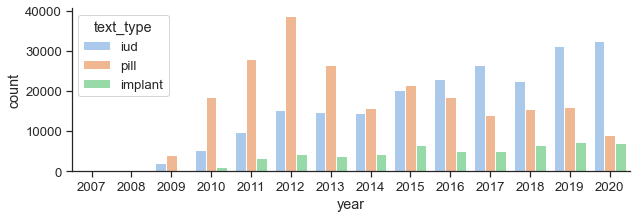

In [45]:
plt.figure(figsize=(10,3))
sns.countplot(data=posts_df,
              x='year',
              hue='text_type',
              palette='pastel',
              order=['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
sns.despine()

<br><br>

# Combine and format replies

In [46]:
replies_dicts = []
for _bc_type in ['iud', 'implant', 'pill']:
    _directory_path = data_directory_path + '/twitter/new-from-api/replies/' + _bc_type
    for _file_name in os.listdir(_directory_path):
        if _file_name.endswith('.json') and 'pagination_tokens' not in _file_name:
            _dicts = json.load(open(_directory_path + '/' + _file_name, 'r'))['data']
            for d in _dicts:

                _year = d['created_at'].split('-')[0]
                _month = d['created_at'].split('-')[1]
                _text = ' '.join(d['text'].split())
                _text = re.sub('@[\w]+', '', _text) # Remove Twitter handles
                _tokens = lmw.process_string(_text)

                if not(_year == '2020' and _month in ['11', '12']) and not(_year == '2021'): # Remove Nov-Dec 2020 to match WebMD
                    replies_dicts.append({'source': 'twitter-replies',
                                          'text': _text,
                                          'tokens_text': _tokens,
                                          'text_type': _bc_type,
                                          'date': d['created_at'],
                                          'year': _year,
                                          'month': _month,
                                          'id': d['id'],
                                          'conversation_id': d['conversation_id'],
                                          'retweet_count': d['public_metrics']['retweet_count'],
                                          'reply_count': d['public_metrics']['reply_count'],
                                          'like_count': d['public_metrics']['like_count'],
                                          'quote_count': d['public_metrics']['quote_count']})
replies_df = pd.DataFrame(replies_dicts)

In [47]:
len(replies_df.index)

273151

### Extract methods from text

In [48]:
replies_df['text_type'] = replies_df['tokens_text'].apply(get_type_from_tokens)

In [49]:
replies_df['text_type'].value_counts()

iud                                                               154649
pill                                                               40573
implant                                                            29766
combo_iud_pill                                                     10835
unknown                                                             9050
combo_implant_iud                                                   4825
combo_barrier_iud                                                   2411
combo_iud_shot                                                      2257
combo_implant_pill                                                  1767
combo_barrier_iud_pill                                              1633
combo_barrier_pill                                                  1546
shot                                                                1487
barrier                                                             1410
combo_iud_sterilization                            

In [50]:
replies_df['text_type'].value_counts(normalize=True)

iud                                                               0.566167
pill                                                              0.148537
implant                                                           0.108973
combo_iud_pill                                                    0.039667
unknown                                                           0.033132
combo_implant_iud                                                 0.017664
combo_barrier_iud                                                 0.008827
combo_iud_shot                                                    0.008263
combo_implant_pill                                                0.006469
combo_barrier_iud_pill                                            0.005978
combo_barrier_pill                                                0.005660
shot                                                              0.005444
barrier                                                           0.005162
combo_iud_sterilization  

In [51]:
print(len(replies_df.index))
replies_df = replies_df[replies_df['text_type'].isin(['pill', 'iud', 'implant'])]
len(replies_df.index)

273151


224988

In [64]:
1 - (224988 / 273151)

0.17632371838287253

In [52]:
replies_df['text_type'].value_counts()

iud        154649
pill        40573
implant     29766
Name: text_type, dtype: int64

### Drop duplicates

In [53]:
replies_df = replies_df.drop_duplicates(subset=['text'])
len(replies_df.index)

219914

### Remove replies not about three target bc types

In [54]:
# keywords = [w for _bc_type, _keywords in category_keywords_dict_small.items() for w in _keywords]
# replies_df = replies_df[replies_df['tokens_text'].str.contains('|'.join(keywords))]
# len(replies_df.index)

### Remove short replies

In [55]:
def get_num_tokens(text):
    if pd.isnull(text):
        return 0
    return len(text.split())

replies_df['num_tokens'] = replies_df['tokens_text'].apply(get_num_tokens)
replies_df = replies_df[(replies_df['num_tokens'] >= 3)]
len(replies_df.index)

211896

### Final dataframe

In [56]:
replies_df.sample(3)

,source,text,tokens_text,text_type,date,year,month,id,conversation_id,retweet_count,reply_count,like_count,quote_count,num_tokens
203525,twitter-replies,nexplanon... it’s the 3 year insert in your a...,nexplanon NUM year insert arm already mine tak...,implant,2019-06-23T00:39:06.000Z,2019,06,1142592885306662912,1142430062777708544,0,1,3,0,16
96093,twitter-replies,Luckily my doctor understood that and never ev...,luckily doctor understood never even suggested...,iud,2017-07-04T11:25:04.000Z,2017,07,882198569729568768,882198005838905347,0,3,0,0,12
229561,twitter-replies,Nexplanon hit me with 6 months non stop ☺️,nexplanon hit NUM months non stop,implant,2020-08-05T09:27:46.000Z,2020,08,1290942565617766400,1290441431568601088,0,0,0,0,6


In [57]:
len(replies_df.index)

211896

In [58]:
replies_df.to_csv(data_directory_path + '/final-data/twitter_replies.csv')

In [59]:
replies_df['text_type'].value_counts(normalize=True)

iud        0.696946
pill       0.184237
implant    0.118818
Name: text_type, dtype: float64

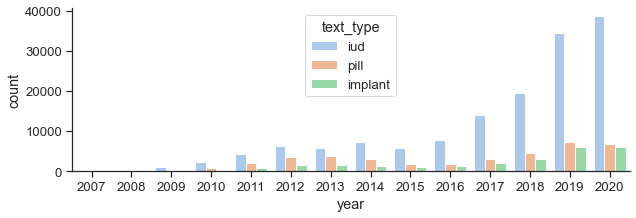

In [60]:
plt.figure(figsize=(10,3))
sns.countplot(data=replies_df,
              x='year',
              hue='text_type',
              palette='pastel',
              order=['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
sns.despine()

In [61]:
replies_df['year'].value_counts()

2020    51576
2019    47666
2018    27287
2017    19054
2014    11682
2012    11346
2013    11115
2016    10875
2015     8844
2011     7311
2010     3580
2009     1439
2008      115
2007        6
Name: year, dtype: int64